In [47]:
from IPython.display import Image

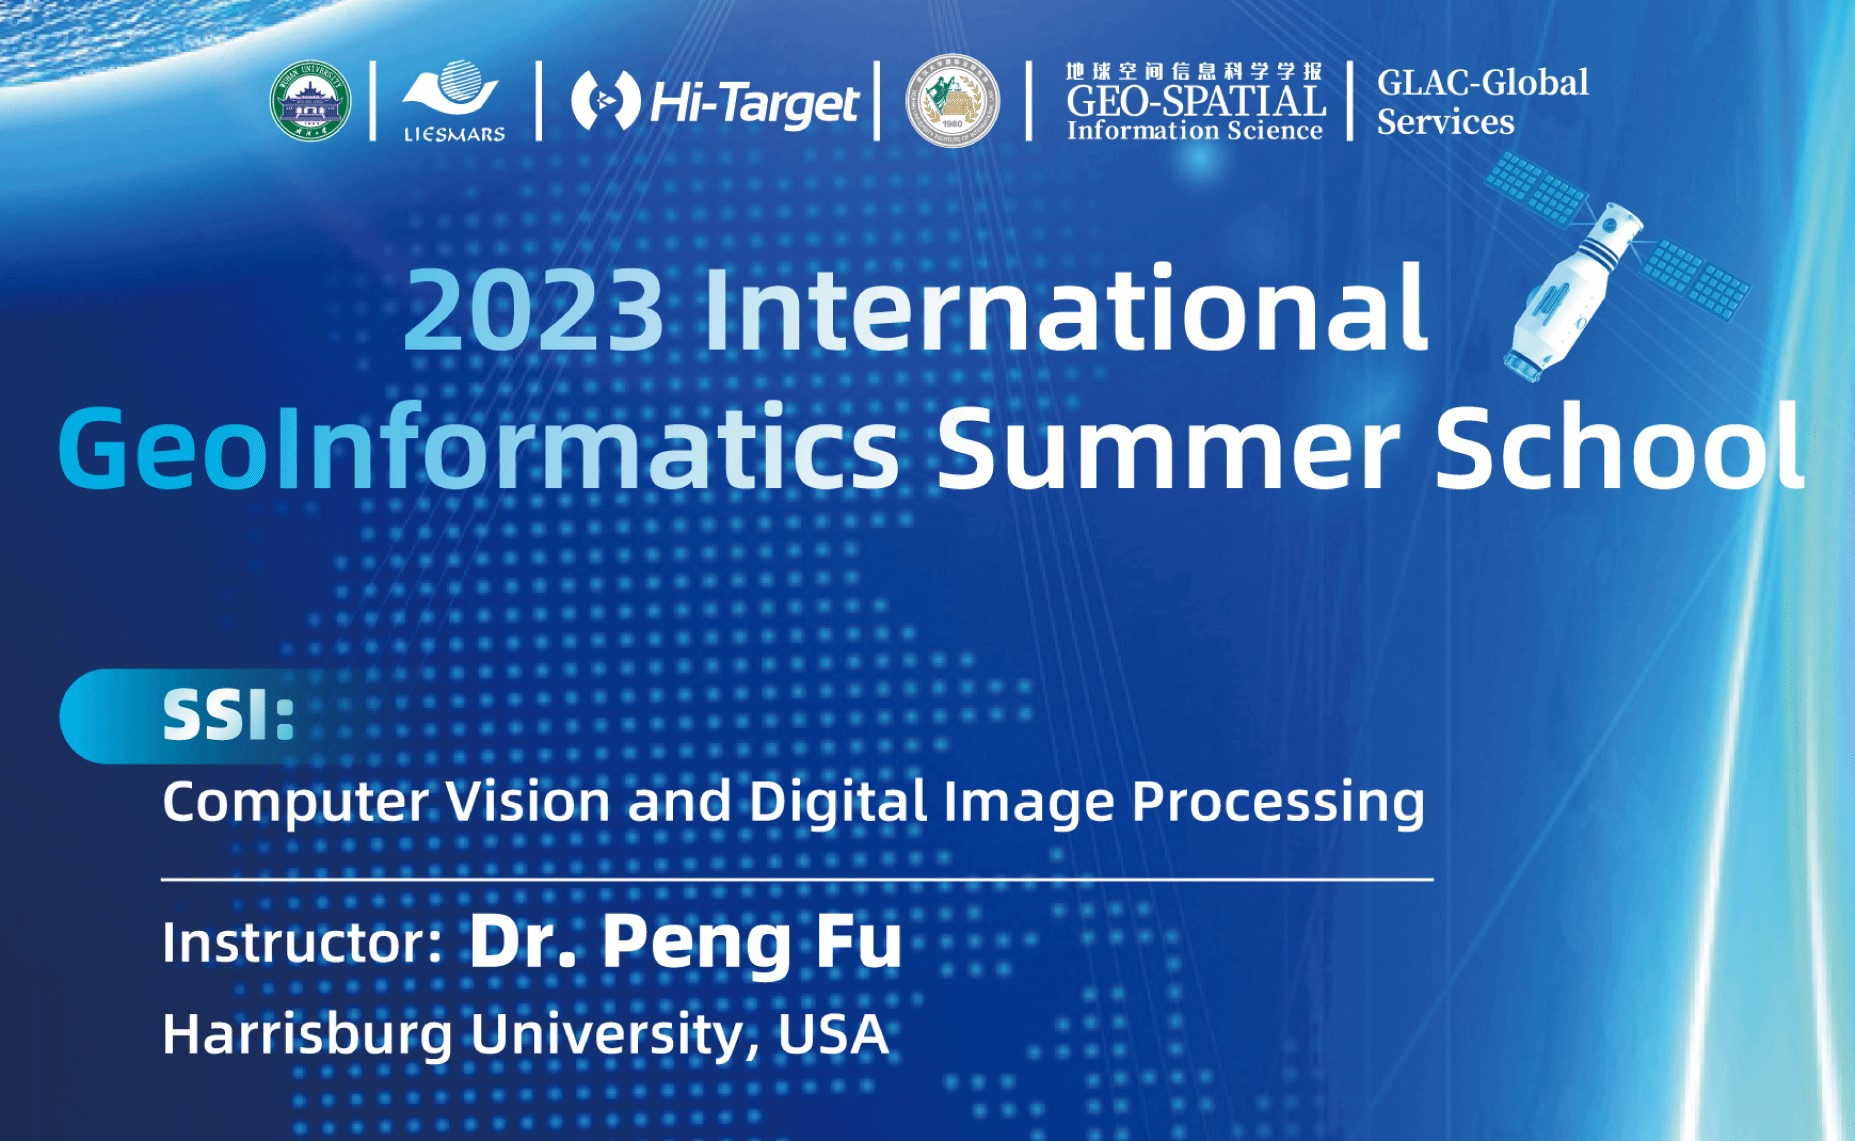

In [48]:
Image(filename='Cover.jpg')

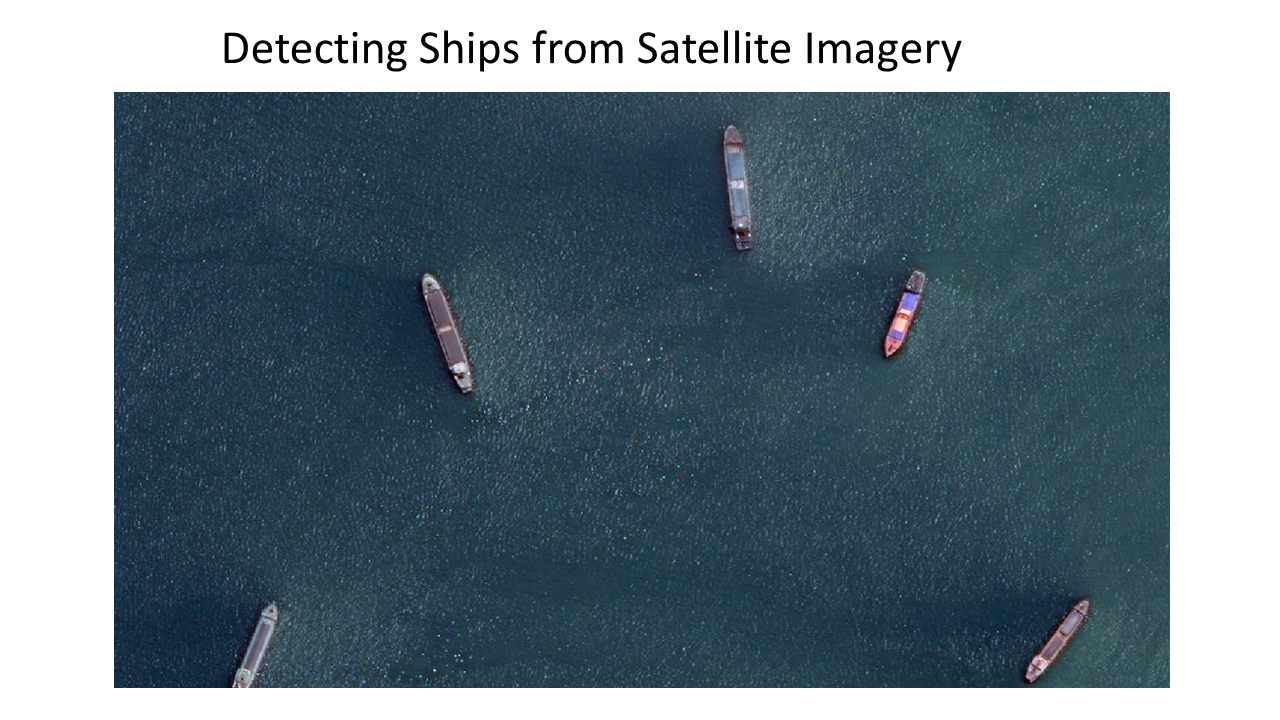

In [49]:
Image(filename='Title.png')

# TASK #2: IMPORT LIBRARIES/DATASETS

In [ ]:
#!pip install pytorch==1.7.1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, transforms
from torchvision import models
import torchvision.transforms.functional as TF
import json, sys, random, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from jupyterthemes import jtplot
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# TASK #1: PROJECT OVERVIEW/ UNDERSTAND THE PROBLEM STATEMENT AND BUSINESS CASE

In [2]:
#!pip install jupyterthemes

In [3]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) 
# setting the style of the notebook to be monokai theme  
# this line of code is important to ensure that we are able to see the x and y axes clearly
# If you don't run this code line, you will notice that the xlabel and ylabel on any plot is black on black and it will be hard to see them. 

In [4]:
# Set random seed for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# TASK #3: PERFORM DATA EXPLORATION AND DATA VISUALIZATION

In [5]:
# Check the number of images in the dataset
train = []
label = []
for i in os.listdir('./Data'):
    train_class = os.listdir(os.path.join('Data', i))
    for j in train_class:
        img = os.path.join('Data', i, j)
        train.append(img)
        label.append(i)
print('Number of train images: {}\n'.format(len(train)))

Number of train images: 4000



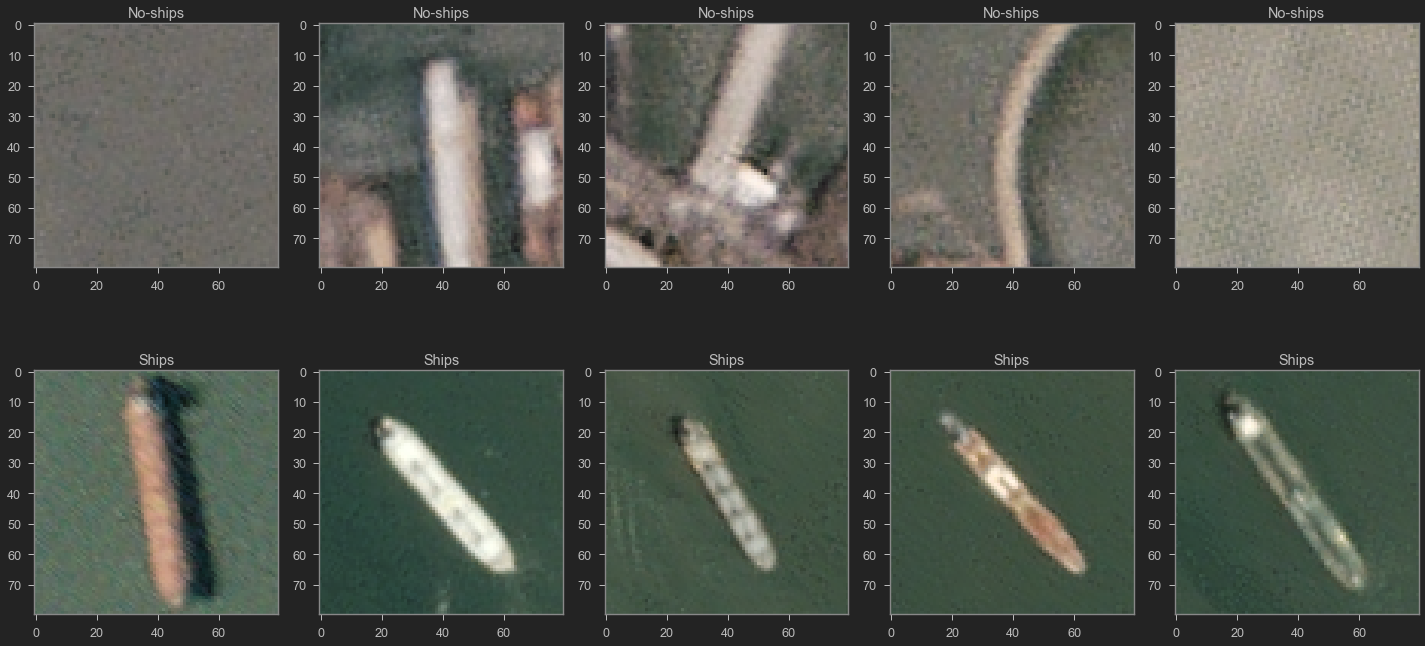

In [6]:
# Visualize the images in the dataset
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
count = 0
for i in os.listdir('./Data'):
    train_class = os.listdir(os.path.join('Data', i))
    for j in range(5):
        img = os.path.join('Data', i, train_class[j])
        img = PIL.Image.open(img)
        axs[count][j].set_title(i)
        axs[count][j].imshow(img)
    count += 1
fig.tight_layout()

In [7]:
# Check the number of images in each class in the training dataset
No_images_per_class = []
Class_name = []
for i in os.listdir('./Data'):
    train_class = os.listdir(os.path.join('Data', i))
    No_images_per_class.append(len(train_class))
    Class_name.append(i)
    print('Number of images in {}: {}\n'.format(i, len(train_class)))

Number of images in No-ships: 3000

Number of images in Ships: 1000



In [8]:
df = pd.DataFrame({'Image': train, 'Labels': label})
df = shuffle(df)

In [9]:
train, test = train_test_split(df, test_size=0.2)

In [10]:
# Extract ships based on their color spectrum
def color_spectrum_visualizer():
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    plt.set_cmap('jet')
    count = 0
    for i in os.listdir('./Data'):
        train_class = os.listdir(os.path.join('Data', i))
        rand = np.random.randint(0, len(train_class))
        for j in range(3):
            img = os.path.join('Data', i, train_class[rand])
            img = PIL.Image.open(img)
            axs[count][j].title.set_text(i)
            channel = np.array(img)[:, :, j]
            axs[count][j].imshow(channel)
        axs[count][3].imshow(img)
        count += 1
    fig.tight_layout()

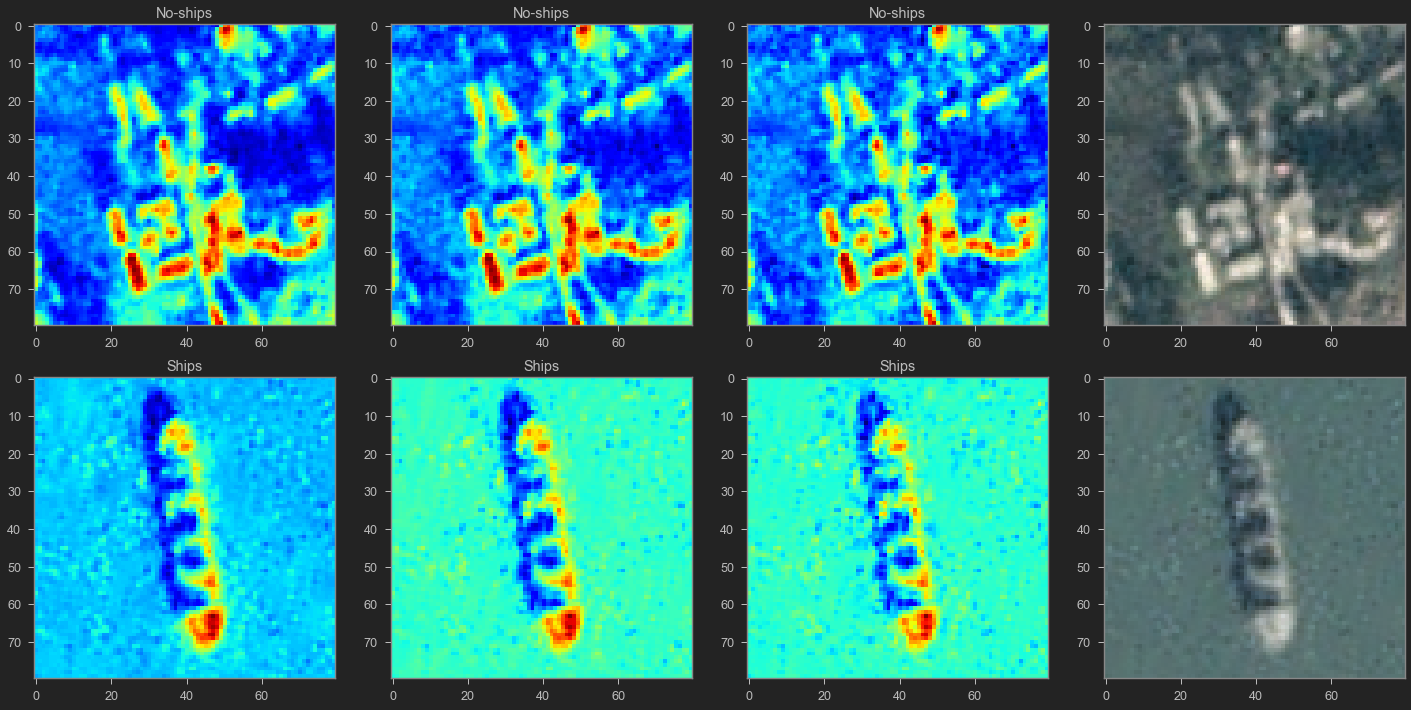

In [11]:
color_spectrum_visualizer()

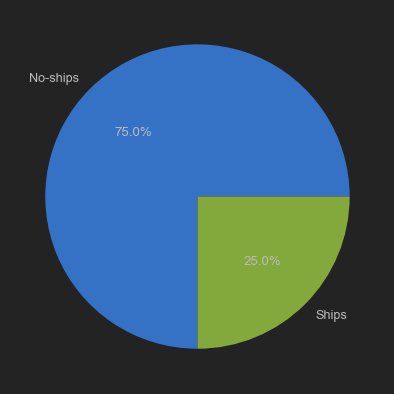

In [12]:
Class_name
fig1, ax1 = plt.subplots()
ax1.pie(No_images_per_class, labels=Class_name, autopct='%1.1f%%')
plt.show()

# TASK #4: PERFORM DATA AUGMENTATION AND CREATE DATA GENERATOR

In [13]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(data['Labels'])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['Image']
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)

In [14]:
# Create runtime augmentation on training and test dataset
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(train, transform=transform_train)
test_dataset = CustomDataset(test, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# TASK #5: UNDERSTAND THE THEORY AND INTUITION BEHIND DEEP LEARNING AND CONVOLUTIONAL NEURAL NETWORKS (CNN)

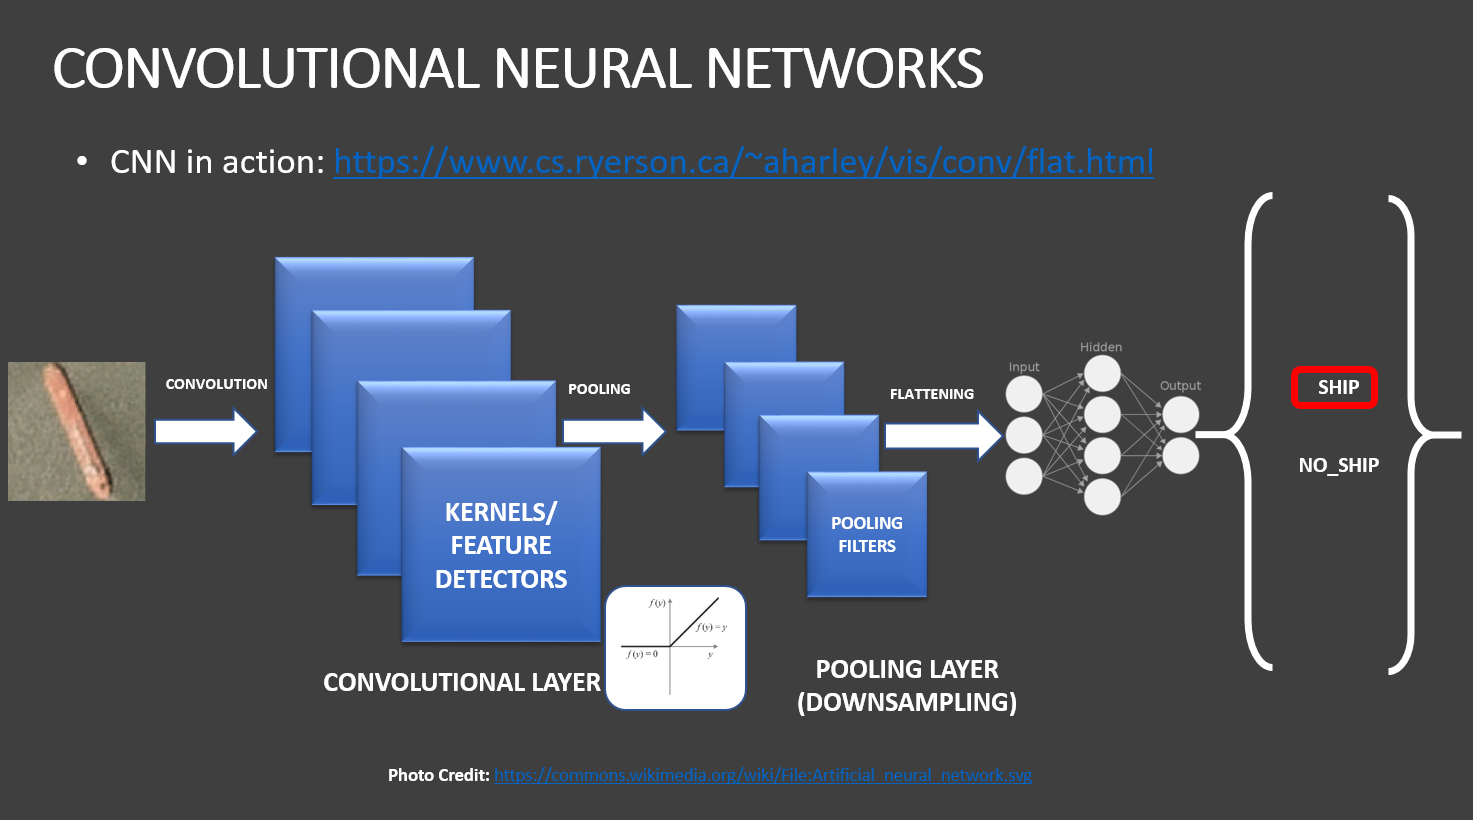

In [40]:
from IPython.display import Image
Image(filename='Image2.png')

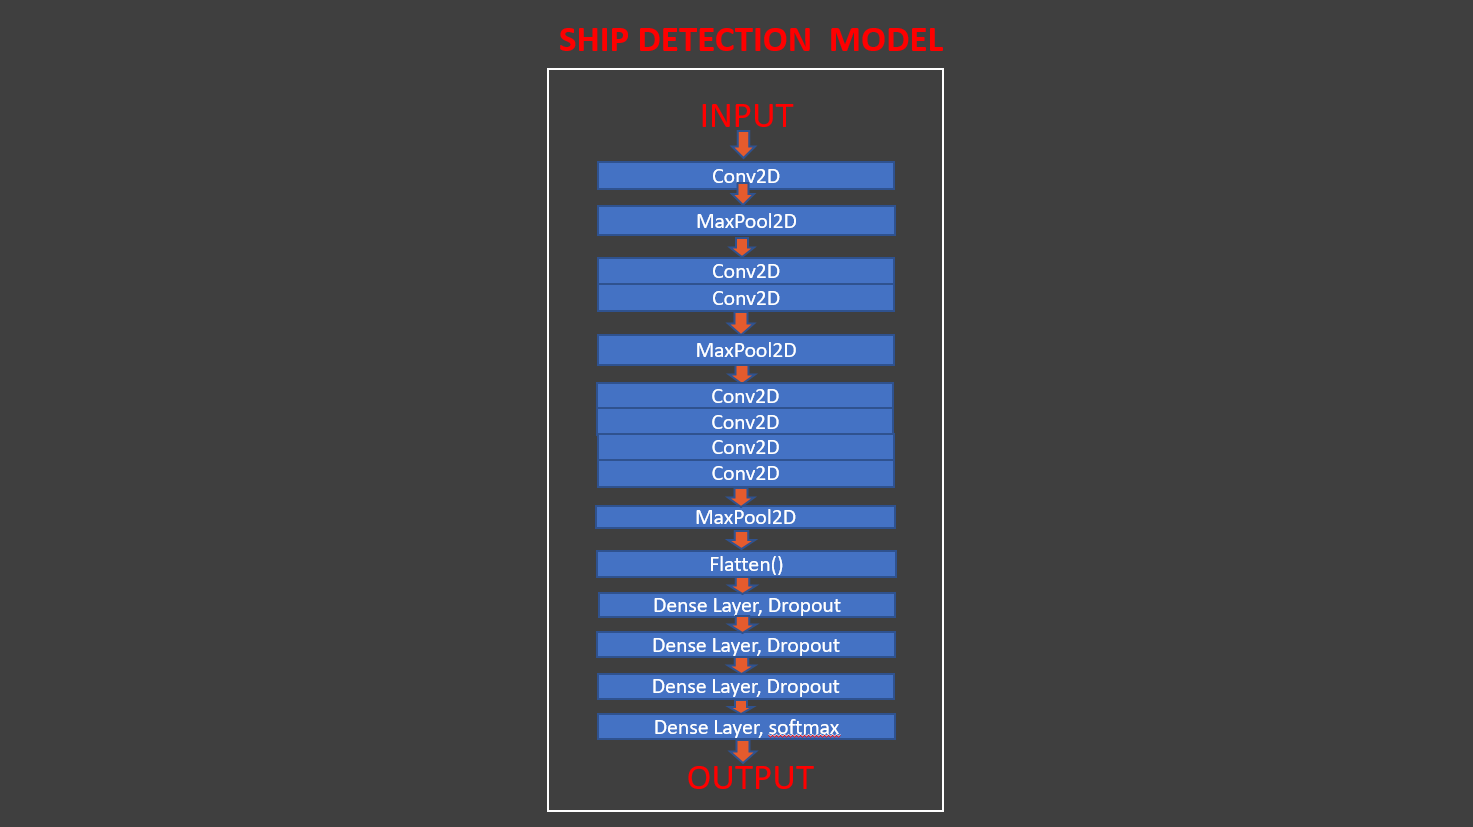

In [41]:
from IPython.display import Image
Image(filename='Image3.png')

# TASK #6: BUILD A DEEP LEARNING MODEL

In [16]:
# Define the model
model = models.vgg16(pretrained=False)
num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1]
features.extend([nn.Linear(num_features, 2)])
model.classifier = nn.Sequential(*features)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, patience=3)

In [18]:
# Training loop
num_epochs = 10
best_loss = float('inf')
best_model_path = 'weights.pth'

# TASK #7: COMPILE AND TRAIN DEEP LEARNING MODEL

In [19]:
# Initialize lists to store training and validation losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    total_samples = 0

    model.train()

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss = train_loss / total_samples
    train_accuracy = 100 * train_correct / total_samples

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            val_loss += loss.item() * images.size(0)

    val_loss = val_loss / total_samples
    val_accuracy = 100 * val_correct / total_samples

    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}%, Val Loss: {:.4f}, Val Accuracy: {:.2f}%'
          .format(epoch + 1, num_epochs, train_loss, train_accuracy, val_loss, val_accuracy))

    scheduler.step(val_loss)

    # Calculate and store training and validation losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Save the best model
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), best_model_path)

print('Training completed!')


Epoch [1/10], Train Loss: 19.9431, Train Accuracy: 73.62%, Val Loss: 0.5361, Val Accuracy: 77.25%
Epoch [2/10], Train Loss: 0.5735, Train Accuracy: 74.44%, Val Loss: 0.5394, Val Accuracy: 77.25%
Epoch [3/10], Train Loss: 0.5718, Train Accuracy: 74.44%, Val Loss: 0.5424, Val Accuracy: 77.25%
Epoch [4/10], Train Loss: 0.5717, Train Accuracy: 74.44%, Val Loss: 0.5424, Val Accuracy: 77.25%
Epoch [5/10], Train Loss: 0.5732, Train Accuracy: 74.44%, Val Loss: 0.5372, Val Accuracy: 77.25%
Epoch [6/10], Train Loss: 0.5712, Train Accuracy: 74.44%, Val Loss: 0.5393, Val Accuracy: 77.25%
Epoch [7/10], Train Loss: 0.5696, Train Accuracy: 74.44%, Val Loss: 0.5388, Val Accuracy: 77.25%
Epoch [8/10], Train Loss: 0.5699, Train Accuracy: 74.44%, Val Loss: 0.5390, Val Accuracy: 77.25%
Epoch [9/10], Train Loss: 0.5697, Train Accuracy: 74.44%, Val Loss: 0.5386, Val Accuracy: 77.25%
Epoch [10/10], Train Loss: 0.5705, Train Accuracy: 74.44%, Val Loss: 0.5387, Val Accuracy: 77.25%
Training completed!


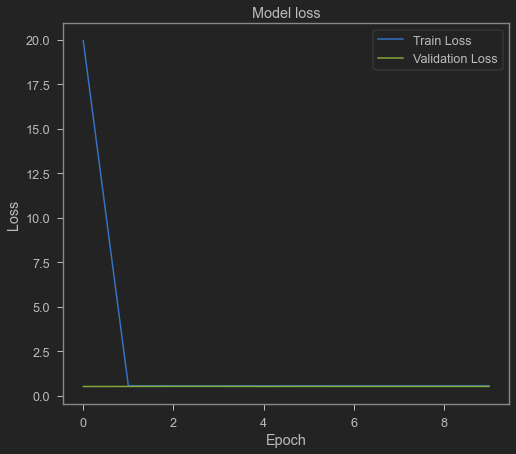

In [20]:
# Plot the model loss and validation loss
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.show()

# TASK #8: ASSESS THE PERFORMANCE OF THE TRAINED MODEL

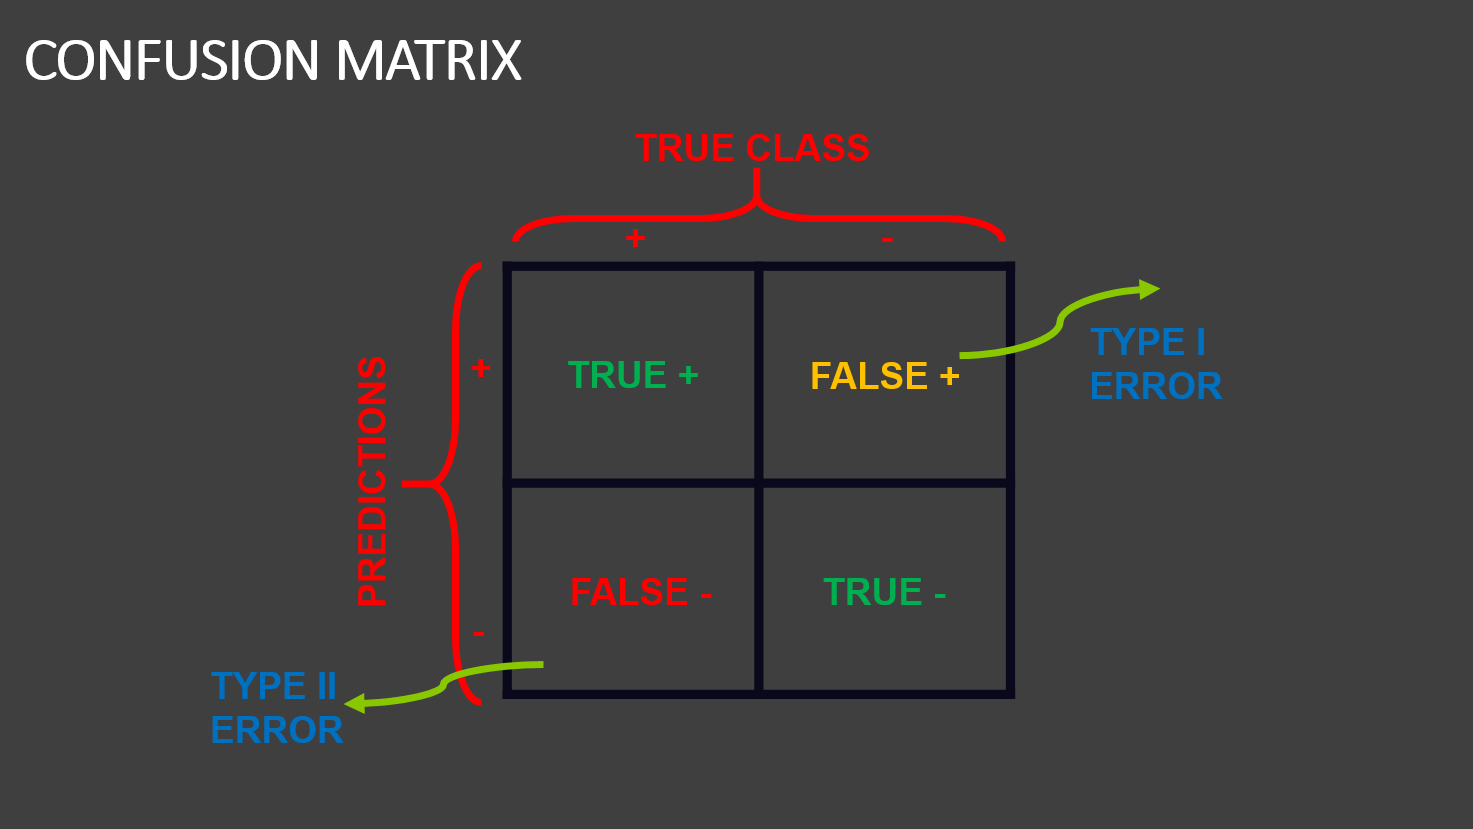

In [42]:
from IPython.display import Image
Image(filename='Image4.png')

In [21]:
# Evaluate the performance of the model
model.eval()
test_correct = 0
total_samples = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

test_accuracy = 100 * test_correct / total_samples
print('Accuracy Test: {:.2f}%'.format(test_accuracy))

Accuracy Test: 77.25%


In [22]:
labels = {0: 'no-ship', 1: 'ship'}

prediction = []
original = []
image = []
count = 0

In [23]:
for item in range(len(test)):
    img_path = test['Image'].tolist()[item]
    img = Image.open(img_path)
    img = img.resize((256, 256))
    image.append(img)
    img = np.array(img, dtype=np.float32)
    img = img / 255
    img = np.expand_dims(img, axis=0)
    img = np.transpose(img, (0, 3, 1, 2))
    img = torch.tensor(img)
    model.eval()
    with torch.no_grad():
        img = img.to(device)
        predict = model(img)
        _, predicted_idx = torch.max(predict, 1)
        predict = predicted_idx.item()
    prediction.append(labels[predict])
    original.append(test['Labels'].tolist()[item])

In [24]:
# Calculate the test accuracy
score = accuracy_score(original, prediction)
print("Test Accuracy: {:.2f}".format(score))

Test Accuracy: 0.00


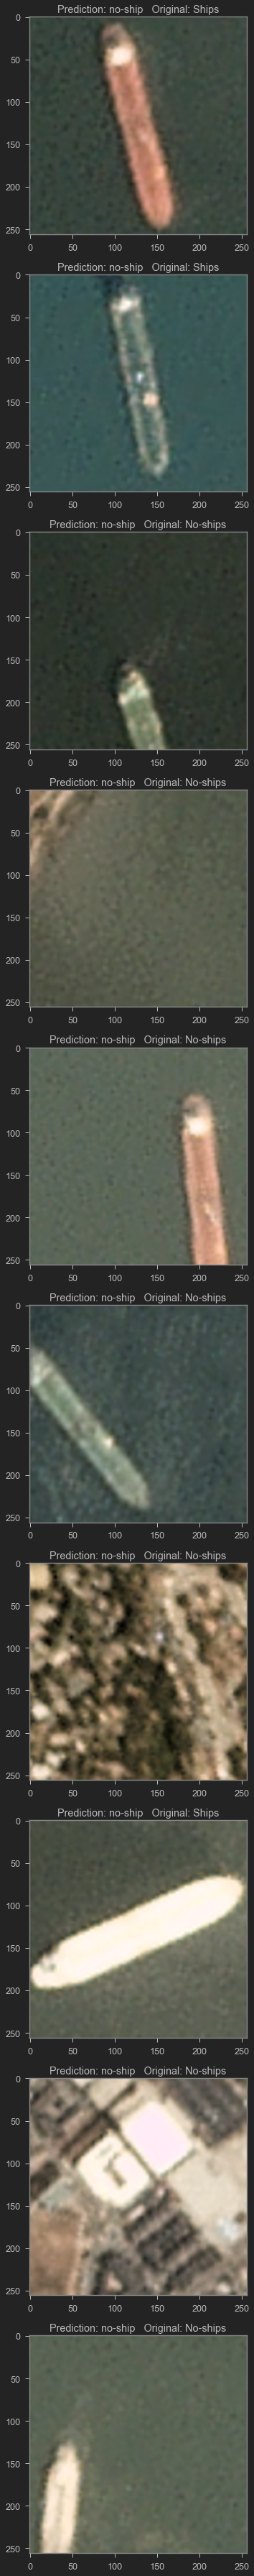

In [25]:
import random

fig, axs = plt.subplots(10, 1, figsize=(50, 50))
count = 0
for i in range(10):
    j = random.randint(0, len(image))
    axs[count].set_title("Prediction: " + prediction[j] + "   Original: " + original[j])
    axs[count].imshow(image[j])
    count += 1
fig.tight_layout()